In [1]:
import pandas as pd
import scipy as sci
import numpy as np
import matplotlib.pyplot as plt
from scipy import io, signal
from scipy.signal import butter, lfilter
import datetime
%matplotlib inline

In [2]:
TP_L = 0
IF_L = 1
IF_R = 2
TP_R = 3
BASELINE = 4
channal_name = []
channal_name.append("TP_L")
channal_name.append("IF_L")
channal_name.append("IF_R")
channal_name.append("TP_R")
channal_name.append("BASELINE")



In [3]:
eegF1_df = pd.read_json('file:eegData_F1.json')
eegF2_df = pd.read_json('file:eegData_F2.json')
eegF3_df = pd.read_json('file:eegData_F3.json')
eegM1_df = pd.read_json('file:eegData_M1.json')
eegM2_df = pd.read_json('file:eegData_M2.json')
eegM3_df = pd.read_json('file:eegData_M3.json')
eegM4_df = pd.read_json('file:eegData_M4.json')
eegM5_df = pd.read_json('file:eegData_M5.json')

eventF1_df = pd.read_json('file:Event_F1.json')
eventF2_df = pd.read_json('file:Event_F2.json')
eventF3_df = pd.read_json('file:Event_F3.json')
eventM1_df = pd.read_json('file:Event_M1.json')
eventM2_df = pd.read_json('file:Event_M2.json')
eventM3_df = pd.read_json('file:Event_M3.json')
eventM4_df = pd.read_json('file:Event_M4.json')
eventM5_df = pd.read_json('file:Event_M5.json')

accelF1_df = pd.read_json('file:accelerometerJson_F1.json')
accelM1_df = pd.read_json('file:accelerometerJson_M1.json')
fs = 256
eventM1_df = eventM1_df[['value', 'timestamp']]
participants_eeg = [eegF2_df, eegF3_df,eegM5_df]
participants_event = [eventF2_df,eventF3_df,eventM5_df]

In [4]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def clean_data(data, fs):
#    print(data.shape)
#    print(np.isnan(data).any())
    mean = np.mean(data)
#    print(data.shape,'Mean: ' + str(mean))
#    print(type(mean))
#    print(mean)
    data = data - mean
#    print(data.shape)
#    print(np.isnan(data).any())
#    print(data)
    data = butter_bandpass_filter(data, .5, 15, fs)
#    print(data)
#    print(data.shape)
#    print(np.isnan(data).any())
    return data

def discard_first_trial(eventlist):
    eventlist = np.delete(eventlist,0,1)
    return eventlist


In [5]:
def datetime_to_float(d):
    epoch = datetime.datetime.utcfromtimestamp(0)
    total_seconds =  (d - epoch).total_seconds()
    # total_seconds will be in decimals (millisecond precision)
    return total_seconds

def compute_EEG_indices(event_timestamps, fs):
    indices = np.array([int(i * fs) for i in event_timestamps]).astype(int)
    return indices

def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

In [6]:
def process_eeg_dataframe(df):
    df_raw_time_vector = df[df['electrode'] == 0]['timestamp'].to_numpy()
    time_spacing = []
    
    for i in np.arange(1,len(df_raw_time_vector)):
        time_spacing.append(df_raw_time_vector[i]-df_raw_time_vector[i-1])

        if(i>1):
            if(not time_spacing[i-1] == time_spacing[i-2]):
                print(time_spacing[i-1],time_spacing[i-2])

    dt_stamp = time_spacing[0]
    dt = dt_stamp / np.timedelta64(1, 's')
    
    T = df_raw_time_vector[-1] - df_raw_time_vector[0] + dt_stamp
    T = T / np.timedelta64(1, 's')

    time_vector = np.arange(0,T,dt/12)
    
    channel_list = []
    eeg_channels = []
    for channel in np.arange(5):
        channel_list.append(df[df['electrode'] == channel])
        eeg_temp = channel_list[channel]['samples'].tolist()
        eeg = []
        for a in eeg_temp:
            for b in a:
                eeg.append(b)
        eeg_channels.append(clean_data(np.array(eeg),fs))
#        print('shape of channel ',channel,': ',eeg_channels[channel].shape)
    eeg_channels = np.array(eeg_channels).squeeze()
    return time_vector,eeg_channels,T

In [7]:
def process_event_dataframe(df,start_time):
    data = df.to_numpy()
    for i in np.arange(len(data)):
        data[i,1] = (datetime_to_float(df["timestamp"][i]) - start_time)
    return data.T

def first_timestamp(df):
    timestamp = df['timestamp'][0]
    return timestamp

In [8]:
def grab_epoch(data, index, fs, len_pre, len_post):
    epoch = np.array([i for i in data[(index+int(len_pre*fs) if index+int(len_pre*fs) >= 0 else 0):index+(len_post*fs)]])
    return epoch

def get_windows(data, indices, fs, len_pre, len_post):
    epoch_list = []
    for index in indices:
        epoch = []
        if index+int(len_pre*fs) < 0 or index+int(len_post*fs) >= len(data): 
            continue
        start = index+int(len_pre*fs) 
        end = index+int(len_post*fs)
        baseline = np.mean(data[start:index])
        for value in data[start:end]:
            epoch.append(value - baseline)
        if(np.var(epoch) > 200):
            continue
        epoch_list.append(epoch)
    return np.array(epoch_list)

In [9]:
time_vector_list = []
eeg_list = []
length_list = []
event_list = []

for i in np.arange(len(participants_eeg)):
#    print(i)
    time_vector,eeg,T = process_eeg_dataframe(participants_eeg[i])
    time_vector_list.append(time_vector)
    eeg_list.append(eeg)
    length_list.append(T)
    event = process_event_dataframe(participants_event[i],datetime_to_float(first_timestamp(participants_eeg[i])))
    event[1] = compute_EEG_indices(event[1], fs)
    event = discard_first_trial(event)
    event_list.append(event)
    
    

#M2_time_vector,M2_eeg,M2_T = process_eeg_dataframe(eegM2_df)
#M3_time_vector,M3_eeg,M3_T = process_eeg_dataframe(eegM3_df)


In [10]:
#print(M2_time_vector.shape,M2_eeg.shape)
print(length_list)
#participants_eeg = [eegF2_df, eegF3_df, eegM1_df, eegM2_df, eegM3_df, eegM4_df, eegM5_df]

[168.796875, 168.796875, 168.796875]


In [11]:
#eventM2_df["timestamp"][0]

In [12]:
M1_offset = datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))
M2_offset = datetime_to_float(eventM2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM2_df))
M3_offset = datetime_to_float(eventM3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM3_df))
M4_offset = datetime_to_float(eventM4_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM4_df))
M5_offset = datetime_to_float(eventM5_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM5_df))
F1_offset = datetime_to_float(eventF1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF1_df))
F2_offset = datetime_to_float(eventF2_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF2_df))
F3_offset = datetime_to_float(eventF3_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegF3_df))

print('M1 offset: ' + str(M1_offset))
print('M2 offset: ' + str(M2_offset))
print('M3 offset: ' + str(M3_offset))
print('M4 offset: ' + str(M4_offset))
print('M5 offset: ' + str(M5_offset))
print('F1 offset: ' + str(F1_offset))
print('F2 offset: ' + str(F2_offset))
print('F3 offset: ' + str(F3_offset))

print((M3_offset + M4_offset)/2)

# note: fix indices for M3 and M4

M1 offset: 11.270625114440918
M2 offset: 11.25
M3 offset: -3165.8001251220703
M4 offset: 3174.6126248836517
M5 offset: 4.40625
F1 offset: 611.2706251144409
F2 offset: 4.40625
F3 offset: 4.453125
4.4062498807907104


In [13]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [14]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [15]:
datetime_to_float(eventM1_df["timestamp"][0]) - datetime_to_float(first_timestamp(eegM1_df))

11.270625114440918

In [16]:
-3165.8001251220703 - 4.40625

-3170.2063751220703

In [17]:
len_pre = -.5
len_post = 1.5

In [18]:
cat_index = []
snake_index = []

for i in np.arange(len(eeg_list)):
    cat_index.append([])
    snake_index.append([])            

epochs_cat = [[],[],[],[],[]]
epochs_snake = [[],[],[],[],[]]


for participant in np.arange(len(eeg_list)):
    for i in np.arange(len(event_list[participant][0])):
#        print(participant,i)
        if(event_list[participant][0][i] < 12):
            cat_index[participant].append(event_list[participant][1][i])
        else:
            snake_index[participant].append(event_list[participant][1][i])






In [19]:
def get_participant_epochs(epochs_cat, epochs_snake, participant):
    for channel in np.arange(5):
        cat_windows = np.array(get_windows(eeg_list[participant][channel], cat_index[participant], fs, len_pre, len_post))
        cat_windows = cat_windows / np.mean(np.abs(cat_windows))
        snake_windows = np.array(get_windows(eeg_list[participant][channel], snake_index[participant], fs, len_pre, len_post))
        snake_windows = snake_windows / np.mean(np.abs(snake_windows))
        for epoch in cat_windows:
            epochs_cat[channel].append(epoch)
        for epoch in snake_windows:
            epochs_snake[channel].append(epoch) 

In [20]:

for participant in np.arange(len(eeg_list)):
       get_participant_epochs(epochs_cat, epochs_snake, participant)
        
epochs_cat = np.array(epochs_cat)

epochs_snake = np.array(epochs_snake)

C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Tamuz\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
#cat_index
#snake_index
#epochs_cat
#epochs_snake
print(np.array(epochs_cat[0]).shape)
print(np.array(epochs_snake[0]).shape)
print(np.mean(epochs_cat[0]))


(36, 512)
(9, 512)
-0.13151600529433627


In [22]:

cat_average = []
snake_average = []
for channel in np.arange(5):
#    print(np.array(epochs_cat[channel]).shape)
    cat_average.append(np.mean(epochs_cat[channel], axis=0))
    snake_average.append(np.mean(epochs_snake[channel], axis=0))

cat_average= np.array(cat_average)
snake_average= np.array(snake_average)

epoch_time = np.arange(len_pre, len_post, 1/fs)

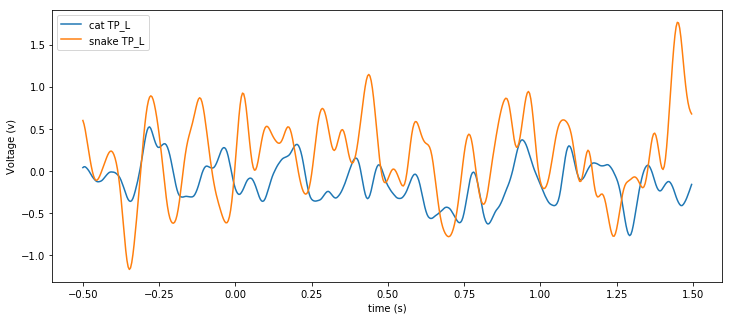

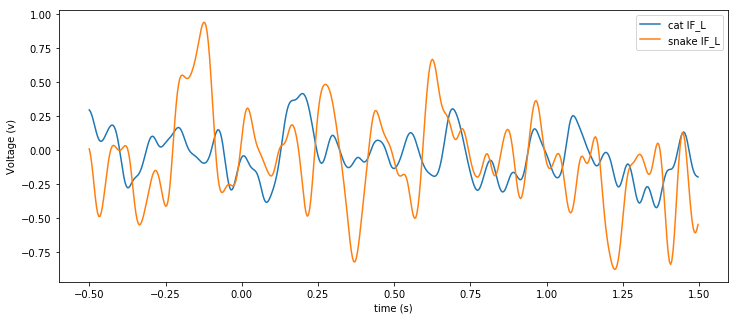

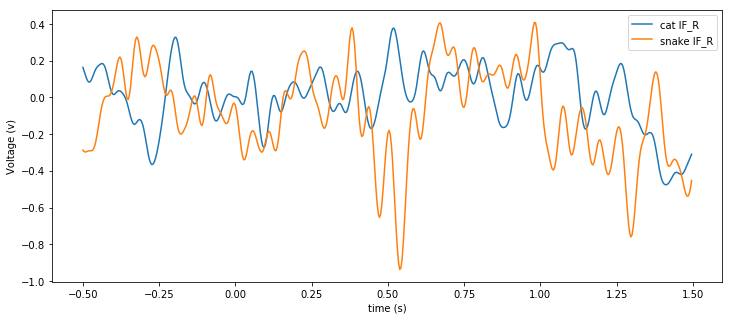

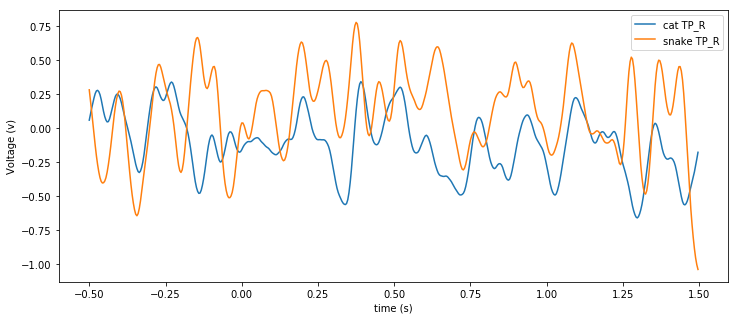

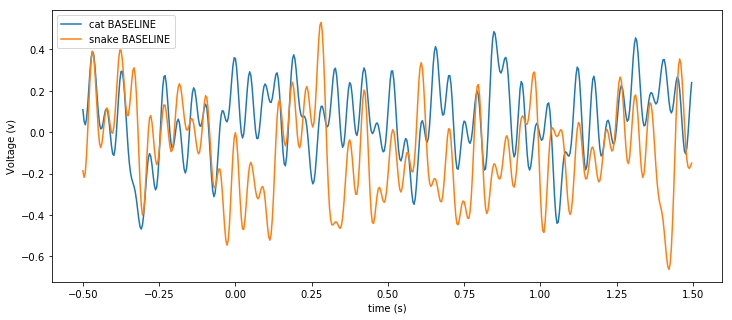

In [23]:
for i in range(0,len(channal_name)):
    # plot STA
    plt.figure(figsize=(12,5))
    plt.plot(epoch_time, cat_average[i], '-', label = "cat " + channal_name[i])
    plt.plot(epoch_time, snake_average[i], '-', label = "snake " + channal_name[i])
    plt.xlabel('time (s)'); plt.ylabel('Voltage (v)');
    plt.legend()


In [24]:
def plot_spectrogram(spg, t, f, freq_lims=[0,100], plot_db=False):
    """
    Utility function for plotting the spectrogram for you.
    
    spg: spectrogram, 2D real-numbered array, dimensions are [frequency x time]
    t: time axis of spectrogram
    f: frequency axis of spectrogram
    freq_lims (optional): limits the frequency axis, defaults to 0-100Hz
    """
    plt.figure(figsize=(15,4))
    if plot_db:
        plt.imshow(10*np.log10(spg), aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    else:
        plt.imshow(spg, aspect='auto', extent=[t[0], t[-1], f[-1], f[0]])
    plt.xlabel('Time'); plt.ylabel('Frequency(Hz)');
    plt.ylim(freq_lims)
    plt.colorbar()
    plt.tight_layout()

# Coherence

In [25]:
participant = 0
max_freq = 3
chan = 0

In [26]:
len_win = 2
len_overlap = 1
f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][chan], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)

# use plot_spectrogram
plot_spectrogram(np.log10(spg), t_stft, f_stft, plot_db=False, freq_lims=[0,20])

# computing welch's spectrogram for you
f_welch, p_welch = signal.welch(np.array(eeg_list)[participant][chan],fs,window='boxcar',nperseg=int(fs*len_win),noverlap=int(fs*len_overlap))
p_welch *= 0.5*len_win # again, undoing scipy's normalization
# plot the PSDs
plt.figure(figsize=(5,5))
plt.plot(f_stft, p_welch, '-', alpha=1, label='psd_welch')
print("max freq = ", np.argmax(p_welch))
max_freq =  np.argmax(p_welch)
plt.legend()
plt.xlim([0,20]);
plt.ylabel('Power')
plt.xlabel('Wave Frequency (Hz)');
print(len(stft))
stft.shape

NameError: name 'spg' is not defined

In [ ]:
def get_coherence_all_freq( f_stft, t_stft, stft, participant,len_win, len_overlap   ):
    
    f_ind = np.arange(0,len(f_stft))

    cat_times = np.array(cat_index[participant] )/ fs
    cat_times = cat_times.astype(int)
    snake_time = np.array(snake_index[participant] )/ fs
    snake_time = snake_time.astype(int)


    #plt.figure(figsize=(5,5))
   # plt.xlabel('Real'); plt.ylabel('Imag')
    normelised_sum = 0
    # plot all trial vectors
    for trial_ind in cat_times - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()
        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial



    X_mean = normelised_sum / len(cat_times)

  #  plt.plot([0,X_mean.real], [0, X_mean.imag], 'ko-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_cat_pre =coherence


    # ---------- now do it for real -------------------
    # get trial indices from trial times

    normelised_sum = 0
    for trial_ind in cat_times:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

     #   plt.plot([0,X_trial.real], [0, X_trial.imag], 'r.--', alpha=0.2)

    X_mean = normelised_sum / len(cat_times)

 #   plt.plot([0,X_mean.real], [0, X_mean.imag], 'ro-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_cat_post = coherence



    normelised_sum = 0
    for trial_ind in snake_time - 1:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

     #   plt.plot([0,X_trial.real], [0, X_trial.imag], 'b.--', alpha=0.2)

    X_mean = normelised_sum / len(snake_time)

   # plt.plot([0,X_mean.real], [0, X_mean.imag], 'bo-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_snake_pre = coherence
    
    normelised_sum = 0
    for trial_ind in snake_time:
        X_trial = stft[f_ind, trial_ind].squeeze()

        # normalize by vector length
        X_trial /= np.abs(X_trial)
        normelised_sum += X_trial

       # plt.plot([0,X_trial.real], [0, X_trial.imag], 'b.--', alpha=0.2)

    X_mean = normelised_sum / len(snake_time)

    #plt.plot([0,X_mean.real], [0, X_mean.imag], 'bo-', alpha=1)

    coherence = np.abs(X_mean)#_YOUR_CODE_HERE
    coherence_snake_post = coherence
    
    return (coherence_cat_pre,coherence_cat_post,coherence_snake_pre, coherence_snake_post)


## Get coherence for each person and for each channal

In [ ]:
coherence_cat_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_pre = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_cat_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
coherence_snake_post = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]
psd = [[[],[],[],[],[]],[[],[],[],[],[]],[[],[],[],[],[]]]

for participant in np.arange(len(eeg_list)):
    for c in range(0,5):
        f_stft, t_stft, stft = signal.stft(np.array(eeg_list)[participant][c], fs, nperseg=fs*len_win,  noverlap=fs*len_overlap, detrend=False)
        spg = np.abs(stft)**2
        psd[participant][c] = np.mean(spg, axis=1) 
        cat_pre, snake_pre, cat_post, snake_post = get_coherence_all_freq(f_stft, t_stft, stft, participant,1,0.5)
        coherence_cat_pre[participant][c] = (cat_pre)
        coherence_snake_pre[participant][c] = (snake_pre)
        coherence_cat_post[participant][c] = (cat_post)
        coherence_snake_post[participant][c] = (snake_post)


In [ ]:
coherence_cat_pre = np.array(coherence_cat_pre)
coherence_snake_pre = np.array(coherence_snake_pre)
coherence_cat_post = np.array(coherence_cat_post)
coherence_snake_post = np.array(coherence_snake_post)
psd = np.array(psd)
psd.shape



In [ ]:
coherence_cat_pre = np.mean(coherence_cat_pre, axis =0)
coherence_snake_pre = np.mean(coherence_snake_pre, axis =0)
coherence_cat_post = np.mean(coherence_cat_post, axis =0)
coherence_snake_post = np.mean(coherence_snake_post, axis =0)
psd = np.mean(psd, axis =0)

In [ ]:
for i in range(0,len(channal_name)):

    psd[i] /= np.linalg.norm(psd[i])

    plt.figure(figsize=(12,5))
    plt.plot(f_stft, coherence_cat_pre[i], '-', alpha=1, label='coherence pre cat'+ channal_name[i])
    plt.plot(f_stft, coherence_cat_post[i], '-', alpha=1, label='coherence post cat'+ channal_name[i])
    plt.plot(f_stft, psd[i], '-', alpha=1, label='psd '+ channal_name[i])


    plt.legend()
    plt.xlim([0,15]);
    plt.ylabel('coherence')
    plt.xlabel('Wave Frequency (Hz)');

    plt.figure(figsize=(12,5))
    plt.plot(f_stft, coherence_snake_pre[i], '-', alpha=1, label='coherence pre snake'+ channal_name[i])
    plt.plot(f_stft, coherence_snake_post[i], '-', alpha=1, label='coherence post snake'+ channal_name[i])
    plt.plot(f_stft, psd[i], '-', alpha=1, label='psd '+ channal_name[i])

    plt.legend()
    plt.xlim([0,15]);
    plt.ylabel('coherence')
    plt.xlabel('Wave Frequency (Hz)');